**Goal: Predict how likely a caseses sentencing is be very different if the convicted person was of a different race.**

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

import pickle
import datetime as dt
import sys
import inspect
import json

sys.path.append('../scripts')
from predict_route import clean_data




Data Source: https://datacatalog.cookcountyil.gov/Courts/Sentencing/tg8v-tm6u/data  
Data Dictionary: https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf  
Data description: https://www.cookcountystatesattorney.org/resources/how-read-data

In [5]:
csv = '../data/Sentencing-cook_county.csv'
#csv = 'https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/rows.csv'
cols = ['CHARGE_COUNT',
        'CHARGE_DISPOSITION', 'OFFENSE_CATEGORY', 'PRIMARY_CHARGE_FLAG',
        'DISPOSITION_CHARGED_OFFENSE_TITLE', 'DISPOSITION_CHARGED_CLASS', 'SENTENCE_JUDGE',
        'SENTENCE_PHASE', 'COMMITMENT_TERM', 'COMMITMENT_UNIT', 'LENGTH_OF_CASE_in_Days',
        'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'INCIDENT_CITY', 'LAW_ENFORCEMENT_AGENCY',
        'LAW_ENFORCEMENT_UNIT', 'SENTENCE_TYPE']
# 'CASE_PARTICIPANT_ID' and 'ARREST_DATE' could be useful if matched with another 
# dataset for including criminal history information
orig_data = pd.read_csv(csv, usecols=cols)
data = orig_data.copy()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# JSON of first example
json_str = orig_data.iloc[0].to_json()
print(json.dumps(json.loads(json_str), indent=2))

{
  "OFFENSE_CATEGORY": "PROMIS Conversion",
  "PRIMARY_CHARGE_FLAG": true,
  "DISPOSITION_CHARGED_OFFENSE_TITLE": "ARMED ROBBERY",
  "CHARGE_COUNT": 1,
  "DISPOSITION_CHARGED_CLASS": "X",
  "CHARGE_DISPOSITION": "Plea Of Guilty",
  "SENTENCE_JUDGE": "James L Rhodes",
  "SENTENCE_PHASE": "Original Sentencing",
  "SENTENCE_TYPE": "Prison",
  "COMMITMENT_TERM": 10.0,
  "COMMITMENT_UNIT": "Year(s)",
  "LENGTH_OF_CASE_in_Days": 1307.0,
  "AGE_AT_INCIDENT": 17.0,
  "RACE": "Black",
  "GENDER": "Male",
  "INCIDENT_CITY": null,
  "LAW_ENFORCEMENT_AGENCY": "PROMIS Data Conversion",
  "LAW_ENFORCEMENT_UNIT": null
}


In [4]:
# get data types for each variable
orig_data_dtypes = ['str' if str(i) is 'object' else str(i) for i in orig_data[cols].dtypes]
dict(zip(cols, orig_data_dtypes))

{'CHARGE_COUNT': 'int64',
 'CHARGE_DISPOSITION': 'str',
 'OFFENSE_CATEGORY': 'str',
 'PRIMARY_CHARGE_FLAG': 'bool',
 'DISPOSITION_CHARGED_OFFENSE_TITLE': 'str',
 'DISPOSITION_CHARGED_CLASS': 'str',
 'SENTENCE_JUDGE': 'str',
 'SENTENCE_PHASE': 'str',
 'COMMITMENT_TERM': 'str',
 'COMMITMENT_UNIT': 'str',
 'LENGTH_OF_CASE_in_Days': 'float64',
 'AGE_AT_INCIDENT': 'float64',
 'RACE': 'str',
 'GENDER': 'str',
 'INCIDENT_CITY': 'str',
 'LAW_ENFORCEMENT_AGENCY': 'str',
 'LAW_ENFORCEMENT_UNIT': 'str',
 'SENTENCE_TYPE': 'str'}

### Clean Data
#### Exclude non-prison setences

In [5]:
# filter to only prison sentences (no jail or probation, etc...)
data = data.loc[data['SENTENCE_TYPE']=='Prison', :]
data = data.drop('SENTENCE_TYPE', axis=1)

In [6]:
#data['ARREST_DATE'] = pd.to_datetime(data['ARREST_DATE'], format='%m/%d/%Y %I:%M:%S %p')

In [7]:
# data set includes arrests from as far back as the 1950's but is
# limited to charges with disposition dates starting 10/10/2012
#data['ARREST_DATE'].sort_values()

#### Standardize race category names

In [8]:
data['RACE'].value_counts()

Black                               95559
White [Hispanic or Latino]          16003
White                               13637
HISPANIC                             2348
White/Black [Hispanic or Latino]      681
Asian                                 423
Unknown                               120
American Indian                        62
ASIAN                                  39
Biracial                                8
Name: RACE, dtype: int64

In [9]:
# standardize race category names
standard_race_map = {'Black': 'Black',
 'White': 'White',
 'HISPANIC': 'HISPANIC',
 'White [Hispanic or Latino]': 'HISPANIC',
 'White/Black [Hispanic or Latino]': 'HISPANIC',
 'ASIAN': 'Asian',
 'Asian': 'Asian',
 'American Indian': 'American Indian',
 'Unknown': 'Unknown',
 'Biracial': 'Black'}

data['RACE'] = data['RACE'].map(standard_race_map)
# we can't compare racial outcomes if race is not known
data = data.loc[data['RACE']!='Unknown', :]

# biracial was just 8 people

#### standardize gender categories

In [10]:
data['GENDER'].value_counts()

Male                          120663
Female                          8235
Unknown                            5
Male name, no gender given         3
Unknown Gender                     2
Name: GENDER, dtype: int64

In [11]:
# standardize gender categories
mask = ~data['GENDER'].isin(['Male', 'Female'])
data.loc[mask, 'GENDER'] = 'Unknown'

#### Normalize commitment term to year units

In [12]:
# convert from object dtype
data['COMMITMENT_TERM'] = data['COMMITMENT_TERM'].astype(float)

In [13]:
data['COMMITMENT_UNIT'].value_counts()

Year(s)         114354
Months           13760
Natural Life       676
Days               204
Term                41
Dollars             15
Hours                4
Weeks                1
Name: COMMITMENT_UNIT, dtype: int64

In [14]:
mask = data['COMMITMENT_UNIT'].isin(['Year(s)', 'Months', 'Natural Life', 'Days'])
data = data.loc[mask, :]

In [15]:
# normalize commitment term to year units
term_divisors = {'Year(s)': 1, 'Months':12, 'Days': 365}

# fill rows where unit is natural life with divsor==1
divisor_col = data['COMMITMENT_UNIT'].map(term_divisors).fillna(1)
data['COMMITMENT_TERM'] = data['COMMITMENT_TERM']/divisor_col

In [16]:
data.loc[data['COMMITMENT_UNIT']=='Natural Life','COMMITMENT_TERM'].value_counts()
# this is very confusing... can you give someone more than 1 natural life
# sentence for the same charge? And what does 0 natural life sentence mean

1.0      407
0.0      101
30.0      99
100.0     47
40.0      16
20.0       2
60.0       1
4.0        1
90.0       1
7.0        1
Name: COMMITMENT_TERM, dtype: int64

In [17]:
# define natural life commitment term as the difference between the median age of the indviduals committed to natural life terms at the time of their offence and the us life expectancy
age_when_committed = data.loc[data['COMMITMENT_UNIT']=='Natural Life', 'AGE_AT_INCIDENT'].median()
natural_life_years = 78 - age_when_committed  # 78 is US life expectancy
natural_life_years
# consider using male us life expectancy

# replace any value for commitment term where natural life is the unit to
# the estimated year equivalent
mask = data['COMMITMENT_UNIT']=='Natural Life'
data.loc[mask,'COMMITMENT_TERM'] = natural_life_years

In [18]:
data = data.drop('COMMITMENT_UNIT',axis=1)
# future: assign normalized term to new var name

In [19]:
data.shape

(128994, 16)

#### Remove variables and obervations with NULL values
Drop cols that had more than 5% nulls, then rows with any null

In [20]:
# look at null values
frac_null = data.isnull().sum()/data.shape[0]
frac_null

OFFENSE_CATEGORY                     0.000000
PRIMARY_CHARGE_FLAG                  0.000000
DISPOSITION_CHARGED_OFFENSE_TITLE    0.000000
CHARGE_COUNT                         0.000000
DISPOSITION_CHARGED_CLASS            0.000093
CHARGE_DISPOSITION                   0.000000
SENTENCE_JUDGE                       0.001915
SENTENCE_PHASE                       0.000000
COMMITMENT_TERM                      0.000000
LENGTH_OF_CASE_in_Days               0.077221
AGE_AT_INCIDENT                      0.037420
RACE                                 0.002450
GENDER                               0.000000
INCIDENT_CITY                        0.090338
LAW_ENFORCEMENT_AGENCY               0.031994
LAW_ENFORCEMENT_UNIT                 0.682598
dtype: float64

In [21]:
# remove cols with more than 5% nulls
mask = (frac_null > .05)
nan_cols = data.columns[mask]
data = data.drop(nan_cols,axis=1)
nan_cols

Index(['LENGTH_OF_CASE_in_Days', 'INCIDENT_CITY', 'LAW_ENFORCEMENT_UNIT'], dtype='object')

In [22]:
# drop rows that include any NaNs
orig_rows = data.shape[0]
data = data.dropna(axis=0)
# fraction of rows dropped by dropping rows with any NaNs
1 - data.shape[0]/orig_rows 

0.04162209094996672

#### Reduce categories in high cardinality variables

In [23]:
data['SENTENCE_JUDGE'].value_counts().describe()

count     232.000000
mean      532.866379
std       784.051617
min         1.000000
25%         3.000000
50%        43.000000
75%       910.250000
max      3579.000000
Name: SENTENCE_JUDGE, dtype: float64

In [24]:
# 50% of charges titles have a only 3 observed sentences, 75% have less than 14
data['DISPOSITION_CHARGED_OFFENSE_TITLE'].value_counts().describe()

count     1026.000000
mean       120.492203
std        814.904363
min          1.000000
25%          1.000000
50%          3.000000
75%         14.000000
max      18253.000000
Name: DISPOSITION_CHARGED_OFFENSE_TITLE, dtype: float64

In [25]:
# fraction of data in categories with n observed examples (to inform cutting categories by
# the number of observed examples)
freqs = data['DISPOSITION_CHARGED_OFFENSE_TITLE'].value_counts()
freqs.groupby(freqs).sum()/data.shape[0]

DISPOSITION_CHARGED_OFFENSE_TITLE
1        0.002686
2        0.001828
3        0.002111
4        0.001683
5        0.001658
           ...   
5490     0.044408
6463     0.052279
7303     0.059074
7597     0.061452
18253    0.147648
Name: DISPOSITION_CHARGED_OFFENSE_TITLE, Length: 156, dtype: float64

In [26]:
n = -30
data['DISPOSITION_CHARGED_OFFENSE_TITLE'].value_counts().iloc[n-30:n]

CRIM TRESPASS TO STATE LAND                                                      1
ATTEMPT HEINOUS BATTERY                                                          1
AGG BTRY/POLICE/DOC/DHS                                                          1
DEL CONCEALED FIR/MINOR/SCHOOL                                                   1
DUI/3RD                                                                          1
AGG ID THEFT/AGE 60+ >$100,000                                                   1
AGGRAVATED ID THEFT/AGE 60+/DOCUMENT MAKING                                      1
LURING OF A MINOR                                                                1
RESIST/OBSTRUCT OFFICER                                                          1
ABUSE/NEGLECT OF ELDERLY OR DISABLED/DEATH/CAREGIVER                             1
ATT HOME INVASION/ARMED W/FIREARM                                                1
CHILD SEX OFFENDER/LOITER PARK                                                   1
THEF

In [27]:
data['DISPOSITION_CHARGED_OFFENSE_TITLE'].value_counts()

POSSESSION OF A CONTROLLED SUBSTANCE                 18253
UNLAWFUL USE OR POSSESSION OF A WEAPON BY A FELON     7597
RETAIL THEFT                                          7303
AGGRAVATED UNLAWFUL USE OF WEAPON                     6463
AGGRAVATED BATTERY                                    5490
                                                     ...  
BUY STOLEN RR FREIGHT                                    1
POSS 200+ GR OTHER SCHED I & II                          1
AGG CRIM SEX ABUSE                                       1
THEFT/BY DECEPTION/PERSON/<300                           1
CARRY/POSS CONCEALED WEAP/2ND                            1
Name: DISPOSITION_CHARGED_OFFENSE_TITLE, Length: 1026, dtype: int64

In [28]:
data['DISPOSITION_CHARGED_CLASS'].value_counts()

4    47683
2    29020
3    17879
1    14192
X    12118
M     2394
A      294
B       18
Z       14
O        6
C        6
P        1
Name: DISPOSITION_CHARGED_CLASS, dtype: int64

In [29]:
def check_cat_dist(data, col_name, thresh=.1, top_n=25):
    '''fraction of data in levels that represent less than 10% of total'''
    freqs = data[col_name].value_counts()
    frac_by_freq = freqs.groupby(freqs).sum()/data.shape[0] # percent of data represented by categories with x members
    thresh = data.shape[0]*thresh
    mask = frac_by_freq.index < thresh
    frac_below_thresh = frac_by_freq[mask].sum() # percent of data in categories that each represent less than 10% of all obs
    num_above_thresh = (~mask).sum() # number of categories which have more than thresh % (e.g. 10%) of data in them
    frac_top_n = freqs[:top_n].sum()/data.shape[0]
    return frac_below_thresh, num_above_thresh, frac_top_n

In [30]:
# look at distribution of obs across categories
thresh = .05
top_n=73
for i in data.select_dtypes('object').columns:
    print(i)
    a,b,c = check_cat_dist(data, i, thresh, top_n)
    print(f'{data[i].unique().shape[0]} categories')
    print(f'{round(a*100,3)}% of categories have less than {thresh*100}% of the data in them')
    print(f'{b} categories have more than {thresh*100}% of the data in them')
    print(f'{round(c*100,3)}% of the data is in the most frequent {top_n} categories', '\n')


# future: turn into transformer with thresh and top_n as params (is that already in OneHotEncoder?)

OFFENSE_CATEGORY
87 categories
45.714% of categories have less than 5.0% of the data in them
5 categories have more than 5.0% of the data in them
99.892% of the data is in the most frequent 73 categories 

DISPOSITION_CHARGED_OFFENSE_TITLE
1026 categories
67.955% of categories have less than 5.0% of the data in them
4 categories have more than 5.0% of the data in them
91.695% of the data is in the most frequent 73 categories 

DISPOSITION_CHARGED_CLASS
12 categories
2.211% of categories have less than 5.0% of the data in them
5 categories have more than 5.0% of the data in them
100.0% of the data is in the most frequent 73 categories 

CHARGE_DISPOSITION
21 categories
3.636% of categories have less than 5.0% of the data in them
2 categories have more than 5.0% of the data in them
100.0% of the data is in the most frequent 73 categories 

SENTENCE_JUDGE
232 categories
100.0% of categories have less than 5.0% of the data in them
0 categories have more than 5.0% of the data in them
91.068

In [31]:
## cutoffs for which categories to include:
    
#OFFENSE_CATEGORY top 25

#DISPOSITION_CHARGED_OFFENSE_TITLE top 40

#CHARGE_DISPOSITION - future

# LAW_ENFORCEMENT_AGENCY - top 20

# SENTENCE_JUDGE - top 73

In [32]:
# reduce cardinality of high cardinality categories
top_ns = {'OFFENSE_CATEGORY':25, 'DISPOSITION_CHARGED_OFFENSE_TITLE': 40,
 'LAW_ENFORCEMENT_AGENCY': 20, 'SENTENCE_JUDGE': 73}

# consolidate infrequent categories
for name, n in top_ns.items():
    combine_cats = data[name].value_counts()[n:].index
    mask = data[name].isin(combine_cats)
    data.loc[mask, name] = 'misc_other'

#### Clip range of COMMITMENT_TERM

In [33]:
# There are 11 prison terms greater than 110 years, these are extreme outliers
# and caused large errors in the model. I clip any all values to 110
mask = data['COMMITMENT_TERM'] > 110
data.loc[mask, 'COMMITMENT_TERM']

8332      2032012.0
8333      2032012.0
32420         999.0
32421         999.0
32422         999.0
32423         999.0
32424         999.0
32425         999.0
32426         999.0
32427         999.0
219979        364.0
Name: COMMITMENT_TERM, dtype: float64

In [34]:
# clip any all value above to 110 years
data['COMMITMENT_TERM'] = data['COMMITMENT_TERM'].clip(upper=110)

In [35]:
predict_cols = data.columns
predict_cols

Index(['OFFENSE_CATEGORY', 'PRIMARY_CHARGE_FLAG',
       'DISPOSITION_CHARGED_OFFENSE_TITLE', 'CHARGE_COUNT',
       'DISPOSITION_CHARGED_CLASS', 'CHARGE_DISPOSITION', 'SENTENCE_JUDGE',
       'SENTENCE_PHASE', 'COMMITMENT_TERM', 'AGE_AT_INCIDENT', 'RACE',
       'GENDER', 'LAW_ENFORCEMENT_AGENCY'],
      dtype='object')

In [37]:
# check that the clean data function does the exact same thing as the cleaning in this notebook.
a = clean_data(orig_data)
assert (a == data).all().all()

### Look at correlation between features

In [16]:
from sklearn.feature_selection import f_classif, chi2


a = np.array([0,1,2,3]).repeat(2).reshape(-1,2).astype('bool')
chi2(a, [0,1,2,3])

(array([1., 1.]), array([0.80125196, 0.80125196]))

In [17]:
#np.c_[[0,1,2,3], list('0123')]# < 0 
a = np.array([0,1,2,3]).repeat(2).reshape(-1,2)

In [ ]:
# 2 kinds of features: numeric and categorical
# 3 kind of relations: numeric-numeric, numeric-categorical, categorical-categorical
# 3 kinds of measures of association: pearson r correlation, ANOVA, chi-sq

### Build Sentence Length Model

**Discussion of Model Goals:**

Predict the the sentence based on a wide range of factors including race, identify scenrios where race is an influential predictor, use the same wide range of factor to identify which are influential in scenarios where race was an influential predictor

- drawback: some factors that might be results of racial bias or might capture information about decisions made with racial bias are included in the model that identifies if race was influential which likely decreases the influence of the varaible race, by decreasing its ability to capture all information about racial bias on the sentence because some information about racial bias is being encoded in these other variables (like charge_count). Maybe a sentitivity test to refit the model and asses the influence of race (and the decrease in model accuracy) as you exclude other variables, allowing you to pinpoint which variables are encoding the most information that could be attributed to race.



____________

Goal: define a measure of racial bias in sentencing, by predicting sentence length based on charge severity and demographic factors, see what gap there is between white and black.

We need a model that identifies different degrees of racial bias given different case/defendent profiles.


Approaches to build racial bias model:
deviation from conditional avg at each level, limited variables
deviation from linear regression prediction, limited variables
deviation from all variable ML prediction

In [34]:
#race, criminal history, future recidivism, charge degree, gender and age
# variables from propublica model

I will not include Charge Title as a feature because it has too much or a long tail of low occuring categories (and too many categories overall to easily handle).
- Potential solutions: using some alternative categorical encoding than one-hot, like mean encoding or other...

In [35]:
#charge_classes = data['DISPOSITION_CHARGED_CLASS'].unique() # if manually setting change 

In [36]:
# train test split
target = 'COMMITMENT_TERM'
x_data = data.drop(target,axis=1)
y_data = data[target]

rng = np.random.RandomState()
rs = rng.get_state()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=rng)

In [37]:
trans = OneHotEncoder(handle_unknown='ignore')
cats = ('cats', trans, x_data.select_dtypes('object').columns)
df_trans = ColumnTransformer([cats], remainder='passthrough')

#orig_x_test, orig_x_train = x_test.copy(), x_train.copy()
x_train = df_trans.fit_transform(x_train)
x_test = df_trans.transform(x_test)

In [38]:
# fit on default params # fit HPO

model = XGBRegressor()
model.fit(X=x_train, y=y_train)
preds = model.predict(x_test)

# future: consider trying catboost bc so many categoricals

In [39]:
# evaluate accuracy
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print('Mean Absolute Error:',mae)
print('Fraction of total target variance accounted for (r^2):', r2)

Mean Absolute Error: 1.7756890689951177
Fraction of total target variance accounted for (r^2): 0.8063562556040881


In [40]:
categorical_transform = ('categorical_transformer', df_trans)
sentence_estimator = ('sentence_estimator', model)
sentence_pipe = Pipeline([categorical_transform, sentence_estimator])

In [50]:
# pickle sentence length model 
if False:
    ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
    with open(f'../saved_models/sentence_pipe_mae{round(mae,3)}_{ts}.pkl', 'wb') as f:
        pickle.dump(sentence_pipe, f, -1)

In [42]:
pd.Series(y_test).describe()

count    30904.000000
mean         5.402694
std          8.541676
min          0.000000
25%          1.500000
50%          3.000000
75%          6.000000
max        110.000000
Name: COMMITMENT_TERM, dtype: float64

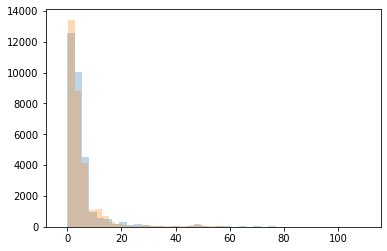

In [43]:
plt.hist(y_test, bins=40, alpha=.3)
plt.hist(preds, bins=40, alpha=.3)
plt.show()

In [44]:
# evaluate error distribution
a = pd.DataFrame({'y_true':y_test,'y_preds':preds})
a['error'] = np.abs(a['y_true'] - a['y_preds'])

a.sort_values('error', ascending=False)
# future: look for patterns in where the error is highest. 
#cluster high erros, or even regress against erros?

,y_true,y_preds,error
219979,110.0,1.765664,108.234336
171265,102.0,20.155760,81.844240
171264,102.0,20.155760,81.844240
1484,105.0,26.231197,78.768803
15310,80.0,3.601948,76.398052
...,...,...,...
133491,2.0,1.999451,0.000549
103649,1.5,1.500452,0.000452
54356,2.0,2.000447,0.000447
70647,4.0,3.999704,0.000296


In [45]:
a.error.describe()

count    30904.000000
mean         1.775689
std          3.312872
min          0.000260
25%          0.388118
50%          0.851495
75%          1.814034
max        108.234336
Name: error, dtype: float64

#### Build Racial discrepancy evaluator

In [73]:
from predict_route import make_counterfactual
print(inspect.getsource(make_counterfactual))

def make_counterfactual(data):
    '''Take data and switch race variable to "opposite" value'''
    # white --> black
    # non-white --> white
    race_counterfactual_map =\
    {'Black': 'White',
    'White': 'Black',
    'HISPANIC': 'White',
    'Asian': 'White',
    'American Indian': 'White'}

    data_counterfactual = data.copy()
    data_counterfactual['RACE'] = data['RACE'].map(race_counterfactual_map)
    return data_counterfactual



In [61]:
from predict_route import estimate_discrepancy
print(inspect.getsource(estimate_discrepancy))

def estimate_discrepancy(model, data):
    '''estimate discrepancy in setnece length if race was switched'''
    diff = model.predict(make_counterfactual(data)) - model.predict(data)
    return diff



In [57]:
rng.set_state(rs) # reset random state for replicable split
x_train, x_test = train_test_split(x_data, random_state=rng)

# we can use the same transformer bc all the categories in the counterfactual 
# should have been seen in train

In [71]:
discrepancy = estimate_discrepancy(sentence_pipe, x_test)
error = y_test - (sentence_pipe.predict(x_test))

In [72]:
# check if error is correlated to the discrepancy
pearsonr(discrepancy, error)
# good that the correlation is not strong between the sentence 

(-0.041331719047177445, 3.6286839445556313e-13)

In [73]:
pd.Series(discrepancy).describe()

count    30904.000000
mean        -0.105365
std          0.636205
min        -10.887285
25%         -0.103147
50%         -0.101215
75%          0.008030
max         13.234074
dtype: float64

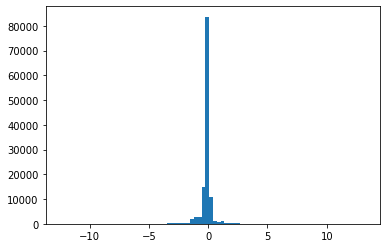

In [65]:
plt.hist(discrepancy,bins=80)
plt.show()

In [80]:
preds = sentence_pipe.predict(x_test)
preds_counterfactual = sentence_pipe.predict(make_counterfactual(x_test))
df = pd.DataFrame({'preds': preds,
                   'preds_counterfactual':preds_counterfactual,
                   'model_error': y_test - preds,
                   'racial_discrepancy': preds_counterfactual - preds
                  })
df.sort_values('racial_discrepancy', ascending=False)

,preds,preds_counterfactual,model_error,racial_discrepancy
2353,38.304379,51.538452,-3.304379,13.234074
54779,3.594712,15.997994,0.905288,12.403282
54783,3.594712,15.997994,0.905288,12.403282
905,38.049328,49.901608,21.950672,11.852280
30170,50.576340,61.570972,-30.576340,10.994633
...,...,...,...,...
172519,23.485662,15.640184,16.514338,-7.845478
2328,65.167206,56.441597,9.832794,-8.725609
94160,34.778000,25.673868,-9.778000,-9.104132
29870,35.395985,24.508699,12.604015,-10.887285


In [47]:
# These racial discrepancies are probably no statistically significant
# Future: look into the really large divergences
b.racial_discrepancy.describe()

count    30904.000000
mean         0.298894
std          0.752823
min          0.000000
25%          0.098587
50%          0.137836
75%          0.251878
max         31.974510
Name: racial_difference, dtype: float64

In [49]:
#np.random.seed(None)
rng = np.random.RandomState()
rs = rng.get_state()
print(rng.rand(1))
rng.set_state(rs)
print(rng.rand(1))

[0.37337184]
[0.37337184]


### Fit Racial bias prediction model
Race is not included in this model

In [50]:
# fit, acc, error dist

In [51]:
# train test split
y_data = bias
x_data = x_data.drop('RACE', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)
orig_x_train, orig_x_test = x_train.copy(), x_test.copy()

In [52]:
trans = OneHotEncoder(handle_unknown='ignore')
cats = ('cats', trans, x_data.select_dtypes('object').columns)
df_trans = ColumnTransformer([cats], remainder='passthrough')

x_train = df_trans.fit_transform(x_train)
x_test = df_trans.transform(x_test)

In [53]:
orig_x_train.columns

Index(['OFFENSE_CATEGORY', 'PRIMARY_CHARGE_FLAG',
       'DISPOSITION_CHARGED_OFFENSE_TITLE', 'CHARGE_COUNT',
       'DISPOSITION_CHARGED_CLASS', 'CHARGE_DISPOSITION', 'SENTENCE_JUDGE',
       'SENTENCE_PHASE', 'AGE_AT_INCIDENT', 'GENDER',
       'LAW_ENFORCEMENT_AGENCY'],
      dtype='object')

In [54]:
# fit on default params # fit HPO

bias_model = XGBRegressor()
bias_model.fit(X=x_train, y=y_train)
preds = bias_model.predict(x_test)

# future: consider trying catboost bc so many categoricals

In [55]:
# evaluate accuracy
print('Mean Absolute Error:',mean_absolute_error(y_test, preds))
print('Fraction of total target variance accounted for (r^2):', r2_score(y_test, preds))

Mean Absolute Error: 0.33555892
Fraction of total target variance accounted for (r^2): 0.9837459544439334


In [56]:
pd.Series(y_test).describe()

count    30904.000000
mean         5.317721
std          7.650752
min         -2.081328
25%          1.706786
50%          3.422073
75%          5.500696
max        101.552589
dtype: float64

In [57]:
# evaluate error distribution
c = pd.DataFrame({'y_true':y_test,'y_preds':preds})
c['error'] = np.abs(c['y_true'] - c['y_preds'])

c.sort_values('error', ascending=False)
# future: look for patterns in where the error is highest. 
#cluster high erros, or even regress against erros?

,y_true,y_preds,error
27848,66.331451,24.529114,41.802338
11126,54.198299,29.842640,24.355659
30191,8.148565,26.433958,18.285393
15304,89.812347,71.714668,18.097679
22544,8.552241,26.498621,17.946381
...,...,...,...
20186,3.062145,3.062108,0.000036
1582,5.985272,5.985239,0.000033
1741,1.311262,1.311289,0.000027
6527,8.666124,8.666148,0.000024


In [58]:
c.error.describe()

count    30904.000000
mean         0.335559
std          0.915866
min          0.000018
25%          0.041195
50%          0.103850
75%          0.254259
max         41.802338
Name: error, dtype: float64

In [59]:
c.y_preds.describe()

count    30904.000000
mean         5.300057
std          7.473743
min         -1.960760
25%          1.713394
50%          3.472389
75%          5.549180
max         98.448921
Name: y_preds, dtype: float64

In [60]:
# build pipeline
categorical_transform = ('categorical_transform', df_trans)
bias_estimator = ('bias_estimator', bias_model)
bias_pipe = Pipeline([categorical_transform, bias_estimator])

In [61]:
# check
a = bias_pipe.predict(orig_x_test)
b = bias_model.predict(x_test)
assert all(a==b)

In [62]:
# visualize feature importance

#bias_model.get_booster().get_fscore() 



In [63]:
# pickle that model (and turn pre processing into a script
if False:
    ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
    with open('../saved_models/bias_pipe'+ts+'.pkl', 'wb') as f:
        pickle.dump(bias_pipe, f, -1)


In [64]:
bias_pipe['categorical_transform'].get_feature_names()

NotImplementedError: get_feature_names is not yet supported when using a 'passthrough' transformer.

In [ ]:
# Predict racial bias
# should race be included in the racial bias prediction model? 
# No, because the bias is symetric, it is as real and notable (although opposite) 
# in for the white convicted person and the black. Could seeing the effect of 
# adding race to the model be a test of its performance (less effect the better)?

Limitations and Future Work:
* we expect past history of convictions to play a significant role in predicting sentence length and be unqually distributed by race. We did not include this factor because limitations in data access, and this is serious limitation in the accuracy of our models. Incorporating this information will be a critical future work step.
* consider class imbalance of black versus white convicted persons
* use age at sentencing not age at incident, to better predict sentence length.

In [ ]:
import sklearn

In [65]:
sklearn.show_versions() ### pip reqs got it wrong!!!!

NameError: name 'sklearn' is not defined

###TODO
- clean up flask notes and schema.. etc...
- historgram of sentence lenghts (target)
- visualize sentence model errors (w.r.t. each var?)
- HPO on xgb
- How predictive is race of sentence length
    - feature importance on sentence model (permutation?)
    - accuracy of sentencing model without race (97% r2 on counterfactual data w/o race) (similar to permutation importance of race)
- In what specifc scenarios, does race play a major factor
    - identify profiles of extreme discrepancy (maybe just from observed examples - or optimization of discrepancy in feature space) where there is a high discrepancy, also optimize on high race shapley scores
    - shapley interpretation of extreme discrepancies, 
    - look for support of race counterfactual holding all other predictors constant (or some like pca of the other predictors)(or nearest neighbor support) on high discrepancy profiles (in addition to model error)
    - generic support of other predictors by race
- What factors (on average) influcene setence discrepancy most?
    - make interpretive sentence discrepancy model
    - accuracy and error viz/check for validity of model
    - Visualize the feature imprtance of setence discrepancy and interpret to answer the q

- turn categorical consolidator into a transformer that can be optimized
- what does the discrepancy mean? Interpret the causal significance of the discrepancy, and the fact that race is not capturing th eway race works thru other variable even the bias of the judges. Consider putting fewer variables into the sentence model, so that the racial counterfactual caputres more contributing factors, use a DAG to show how race can capture the effect of other variables
-clean notebook
-get feedback from causal inference folks (the problem is that while I have conditioned, I haven't conditioned on a theoretically grounded backdoor set) - CPAT person, the telaviv person
- share with CPAT, maybe even request a code review and share with analyze chapter



- deploy w/o container
- install dependencies via: poetry install OR requirements.txt 
-  \+ run flask (which serves to (default) 5000 port on my public IP?)
-  in src/ dir
```
export FLASK_ENV=development
export FLASK_APP=server.py
flask run
```

default port is 5000 for flask apps


- docker container deploy
- the flask env vars are set by special env vars of the docker image
- each image/application server has their own start script for flask
- be in python/ dir
```
docker build -t embrace2020 .
docker run -d -p 4000:80 embrace2020:latest
```
    



alpine linux --very stripped down linux
- no binary wheels for for alpine linux numpy sklearn, etc so required build from source...


tcp - has guarantees that data will arrive resend until it arrives, slower bc there is all the meta communication, requires buffering things to make sure connection is alive, which makes "live" delayed
udp - can loose packets, but will stay live.. its ok if ther eis ome data loss, no acknoleges